In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [3]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes
from decoders import lr_decode_windowed

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### What are the subspace angles between subsequent T and noise levels in FCCA?

In [4]:
# Load the usual dataframe for comparison
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
with open('/mnt/Secondary/data/postprocessed/sabes_varyingT_dimreduc_df.dat', 'rb') as f:
    rl = pickle.load(f)
Tvardf = pd.DataFrame(rl)

In [6]:
with open('/mnt/Secondary/data/postprocessed/sabes_obsnoise_dimreduc_df.dat', 'rb') as f:
    rl = pickle.load(f)
obsnoisedf = pd.DataFrame(rl)

In [8]:
Tvardf.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'data_file', 'loader', 'loader_args',
       'task_args', 'data_path', 'results_file'],
      dtype='object')

In [13]:
Tvardf.iloc[4]['dimreduc_args']

{'T': 3, 'loss_type': 'trace', 'n_init': 10}

In [ ]:
T = np.array([3, 4, 5, 6, 10])


In [27]:
# First comparing subspace angles between varying T
dimreduc_args = [{'T': 3, 'loss_type': 'trace', 'n_init': 1}, {'T': 4, 'loss_type': 'trace', 'n_init': 1},
                 {'T': 5, 'loss_type': 'trace', 'n_init': 1}, {'T': 6, 'loss_type': 'trace', 'n_init': 1}, {'T': 10, 'loss_type': 'trace', 'n_init': 1}]

data_files = np.unique(Tvardf['data_file'].values)
D = 6

ssa = np.zeros((len(data_files), 5, 4, 400))
for i, data_file in enumerate(data_files):
    for fold_idx in range(5):
        df_ref = apply_df_filters(Tvardf, data_file=data_file, fold_idx=fold_idx, dimreduc_args=dimreduc_args[0], dim=D)
        assert(df_ref.shape[0] == 20)
        coef_ref = []
        for k in range(df_ref.shape[0]):
            coef_ref.append(df_ref.iloc[k]['coef'])

        for j, dimreduc_arg in enumerate(dimreduc_args[1:]):
            df_ = apply_df_filters(Tvardf, data_file=data_file, fold_idx=fold_idx, dimreduc_args=dimreduc_arg, dim =D)
            assert(df_.shape[0] == 20)
            coef = []
            for k in range(df_.shape[0]):
                coef.append(df_.iloc[k]['coef'])

            ssa_ = []
            for k1 in range(20):
                for k2 in range(20):
                    ssa_.append(np.mean(scipy.linalg.subspace_angles(coef_ref[k1], coef[k2])))
            ssa[i, fold_idx, j, :] = ssa_

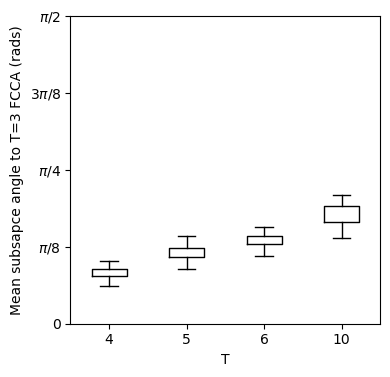

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot([np.min(ssa[..., 0, :], axis=-1).ravel(), np.min(ssa[..., 1, :], axis=-1).ravel(), 
            np.min(ssa[..., 2, :], axis=-1).ravel(), np.min(ssa[..., 3, :], axis=-1).ravel()], medianprops={'linewidth':0}, showfliers=False)
ax.set_xticklabels([4, 5, 6, 10])
ax.set_xlabel('T')
ax.set_ylabel('Mean subsapce angle to T=3 FCCA (rads)')
ax.set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/Tvar.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
Tvardf.iloc[0]

In [29]:
# First comparing subspace angles between adding observation noise
dimreduc_args = [{'T': 3, 'loss_type': 'trace', 'n_init': 1, 'obs_noise':0}, {'T': 3, 'loss_type': 'trace', 'n_init': 1, 'obs_noise':0.0001}, 
                 {'T': 3, 'loss_type': 'trace', 'n_init': 1, 'obs_noise':0.001},
                 {'T': 3, 'loss_type': 'trace', 'n_init': 1, 'obs_noise':0.01}, {'T': 3, 'loss_type': 'trace', 'n_init': 1, 'obs_noise':0.1}]

data_files = np.unique(obsnoisedf['data_file'].values)
D = 6

ssa_onoise = np.zeros((len(data_files), 5, 4, 400))
for i, data_file in enumerate(data_files):
    for fold_idx in range(5):
        df_ref = apply_df_filters(obsnoisedf, data_file=data_file, fold_idx=fold_idx, dimreduc_args=dimreduc_args[0], dim=D)
        assert(df_ref.shape[0] == 20)
        coef_ref = []
        for k in range(df_ref.shape[0]):
            coef_ref.append(df_ref.iloc[k]['coef'])

        for j, dimreduc_arg in enumerate(dimreduc_args[1:]):
            df_ = apply_df_filters(obsnoisedf, data_file=data_file, fold_idx=fold_idx, dimreduc_args=dimreduc_arg, dim =D)
            assert(df_.shape[0] == 20)
            coef = []
            for k in range(df_.shape[0]):
                coef.append(df_.iloc[k]['coef'])

            ssa_ = []
            for k1 in range(20):
                for k2 in range(20):
                    ssa_.append(np.mean(scipy.linalg.subspace_angles(coef_ref[k1], coef[k2])))
            ssa_onoise[i, fold_idx, j, :] = ssa_

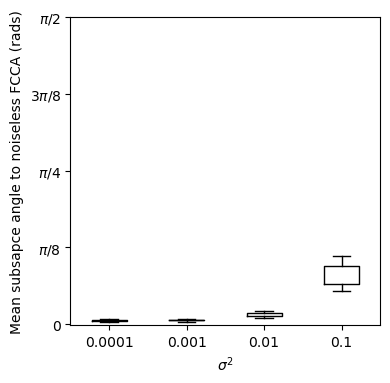

In [32]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot([np.min(ssa_onoise[..., 0, :], axis=-1).ravel(), np.min(ssa_onoise[..., 1, :], axis=-1).ravel(), 
            np.min(ssa_onoise[..., 2, :], axis=-1).ravel(), np.min(ssa_onoise[..., 3, :], axis=-1).ravel()], medianprops={'linewidth':0}, showfliers=False)
ax.set_xticklabels([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xlabel(r'$\sigma^2$')
ax.set_ylabel('Mean subsapce angle to noiseless FCCA (rads)')
ax.set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/onoise.pdf', bbox_inches='tight', pad_inches=0)